# Grid Plots of Fold Change Comparisons by Tissue

**Hypothesis:** GTEx is a better fit to its counterpart tissue in TCGA than a random GTEx tissue given sufficient sample size.

**Method:** Using DESeq2 normalized expression counts, compute log2 fold change (l2fc) between GTEx and Tumor and compare to the l2fc between TCGA normal and tumor by plotting concordance and estimating pearson correlation. Repeat for all GTEx tissues to produce a grid. Repeat for all tissues.

**Algorithm**

- for $t_1 \in \mathcal{T}$
    - compute l2fc Normal vs. Tumor for $t_1$
    - for $t_2 \in \mathcal{T}$
        - Compute l2fc GTEx ($t_2$) vs. Tumor ($t_1$)
        - Compute Pearson Correlation
        - Plot regplot
        - Save gridplot

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats.stats import pearsonr
import seaborn as sns
sns.set_style('whitegrid')

from rnaseq_lib.utils import mkdir_p
from rnaseq_lib.de import get_l2fc
from rnaseq_lib.utils.tissues import return_samples

## Prepare Input Data

Create output directory for grid images

In [2]:
mkdir_p('grid-plots')

Collect tissues

In [4]:
samples = return_samples()

Determine which tissues have TCGA normal samples for comparison

In [31]:
normal_tissues = sorted([x for x in samples if any([y for y in samples[x] if y.endswith('11')])])

In [19]:
print 'These tissues have no TCGA normal: {}'.format(', '.join(set(samples).difference(set(gtex_tissues))))

These tissues have no TCGA normal: Testis, Ovary


Read in DESeq2 normalized expression matrix

In [20]:
df_path = '/mnt/rna-seq-analysis/data/xena/deseq2_normalized_tcga_gtex_counts.tsv'
df = pd.read_csv(df_path, sep='\t', index_col=0)

## Gridplots 

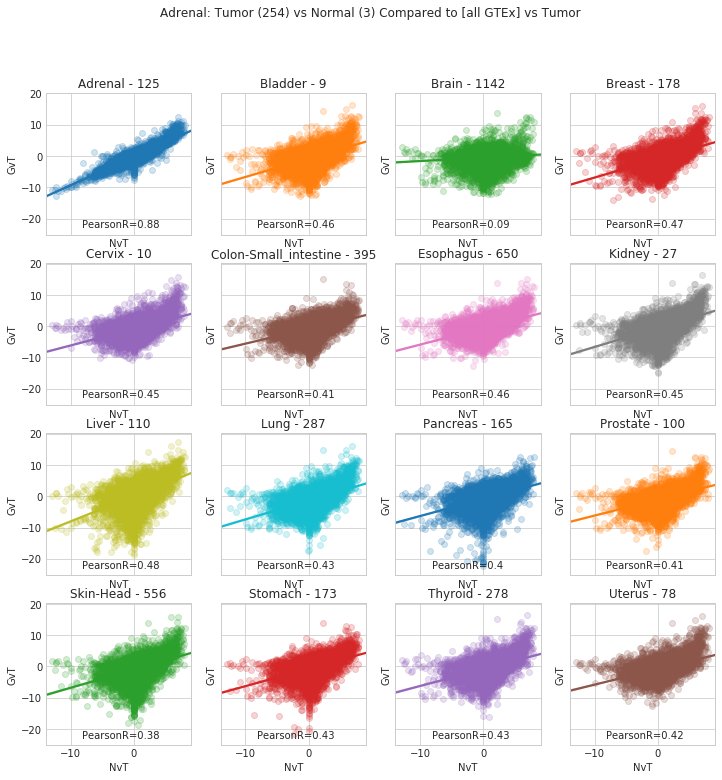

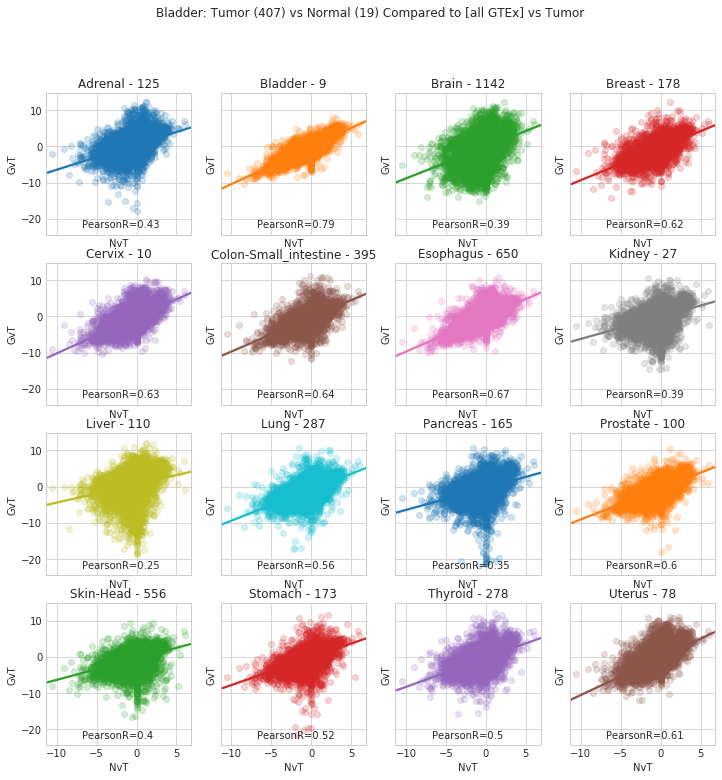

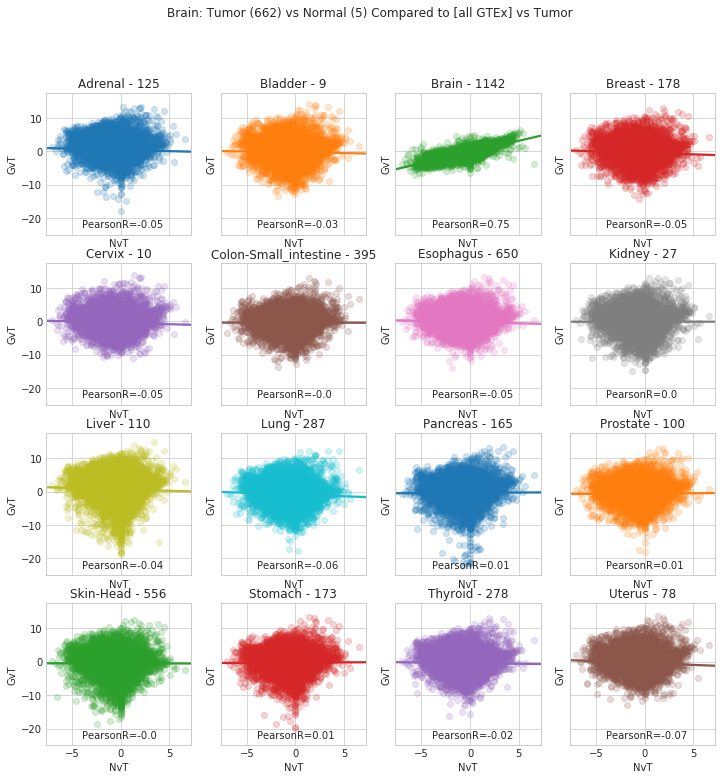

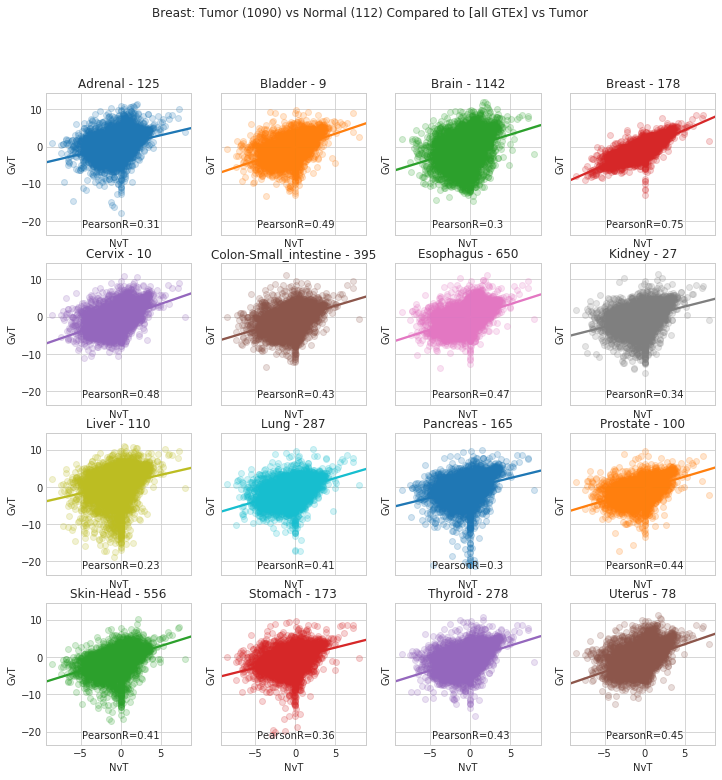

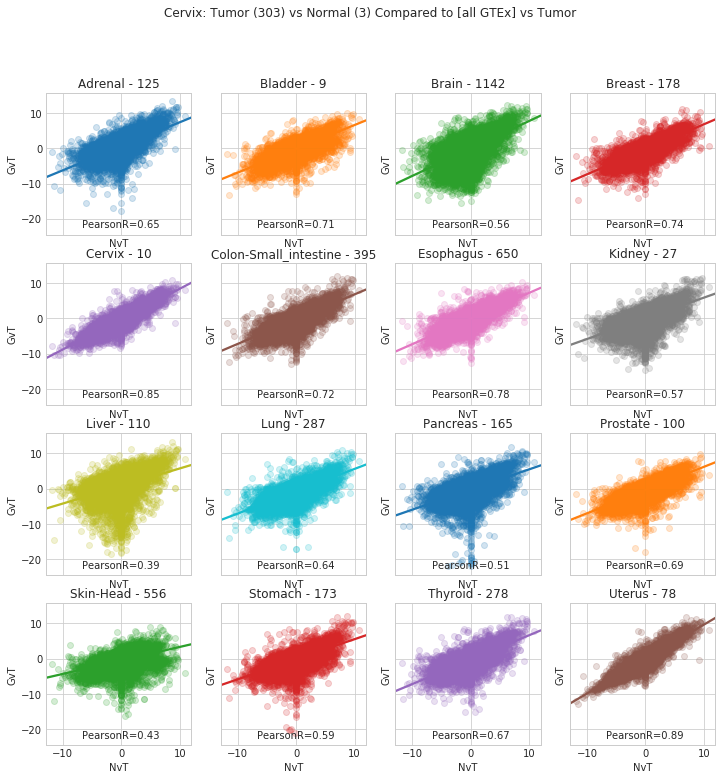

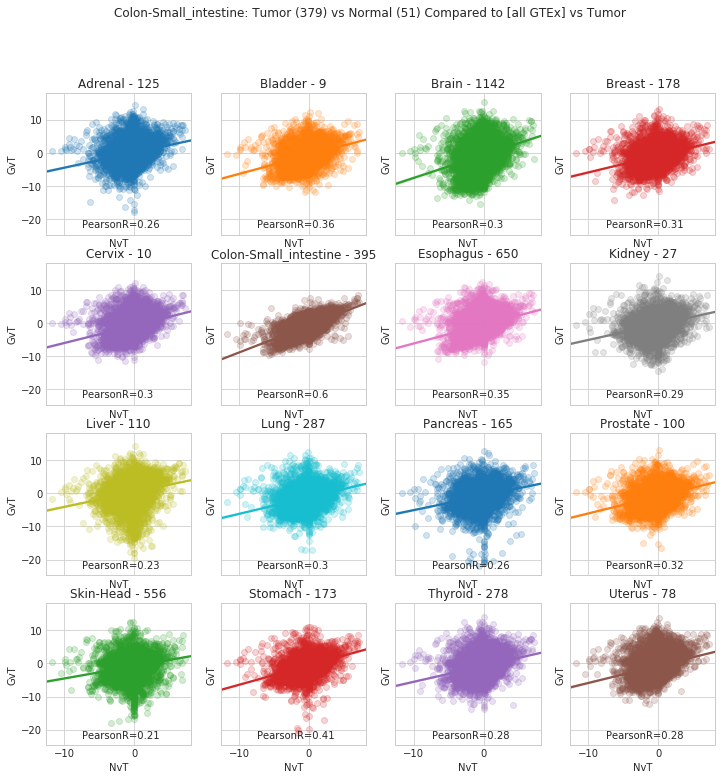

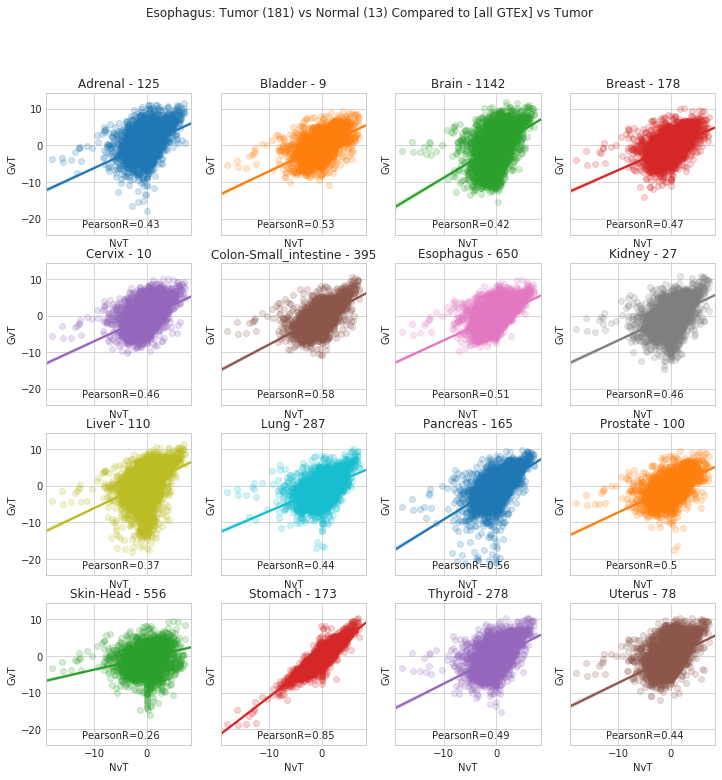

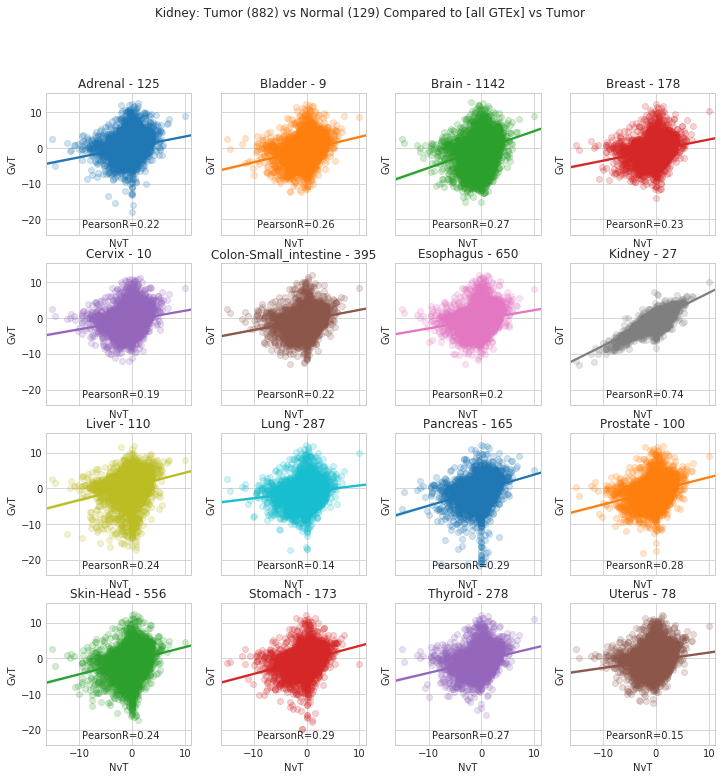

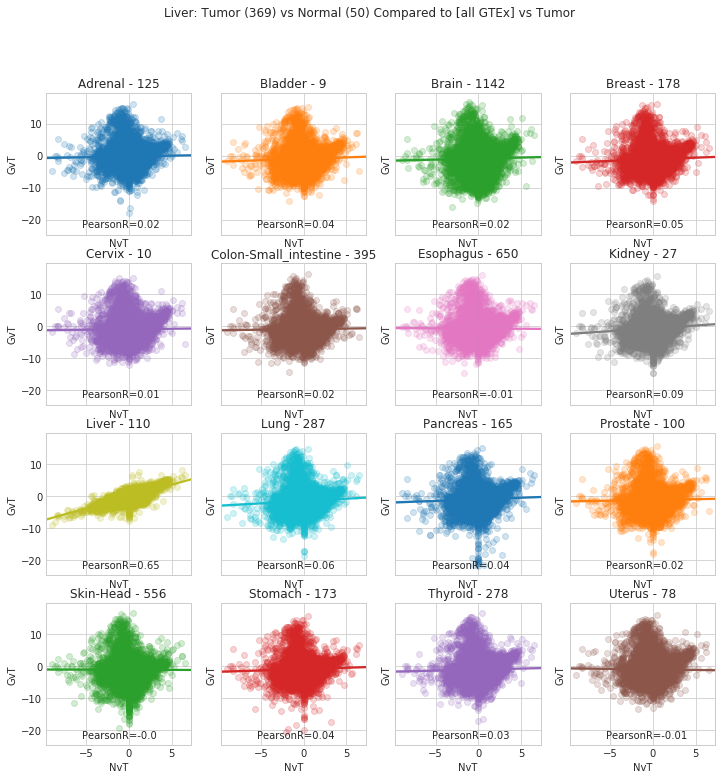

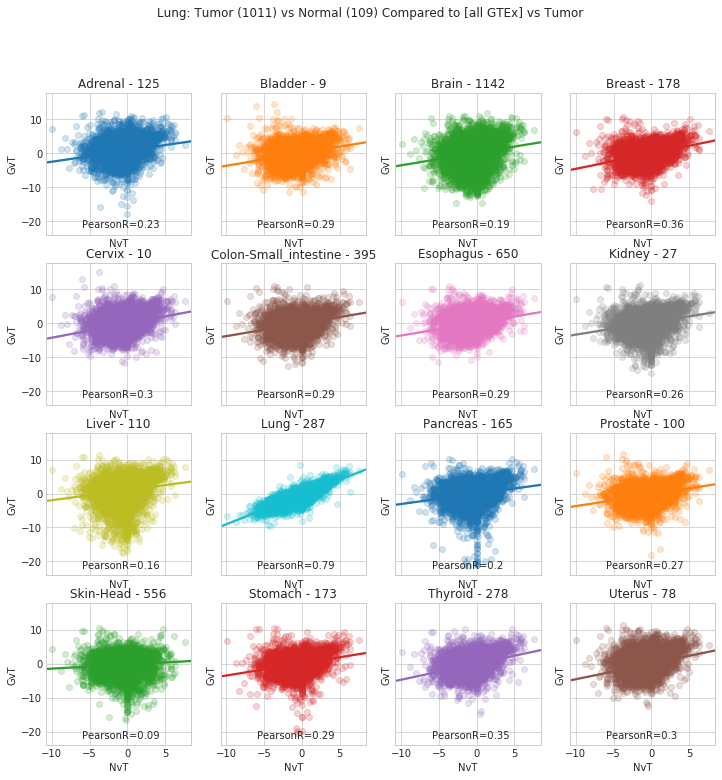

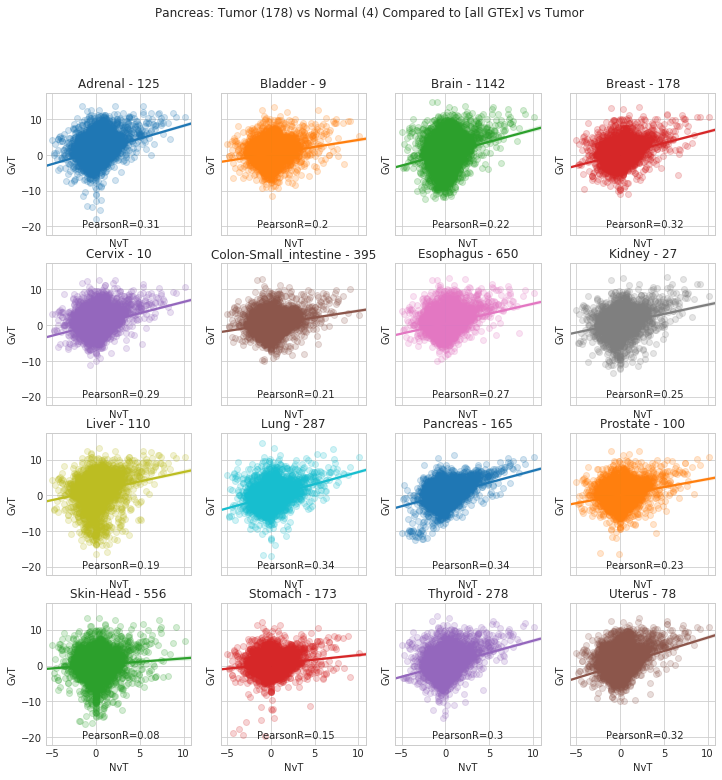

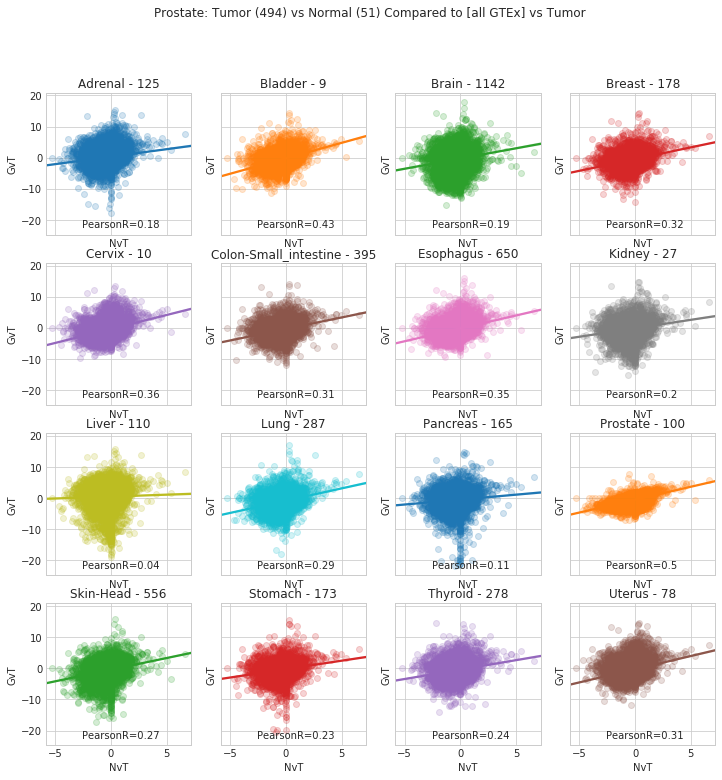

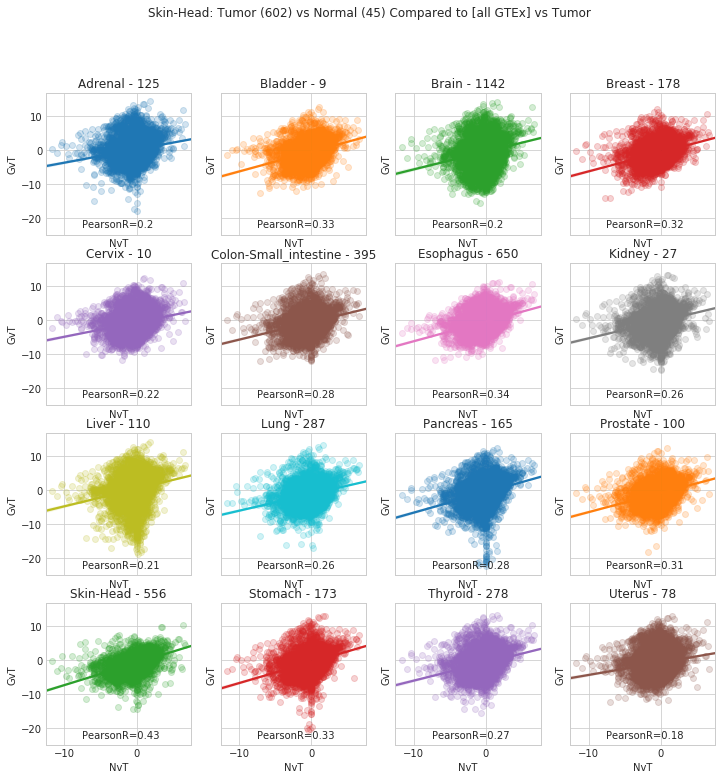

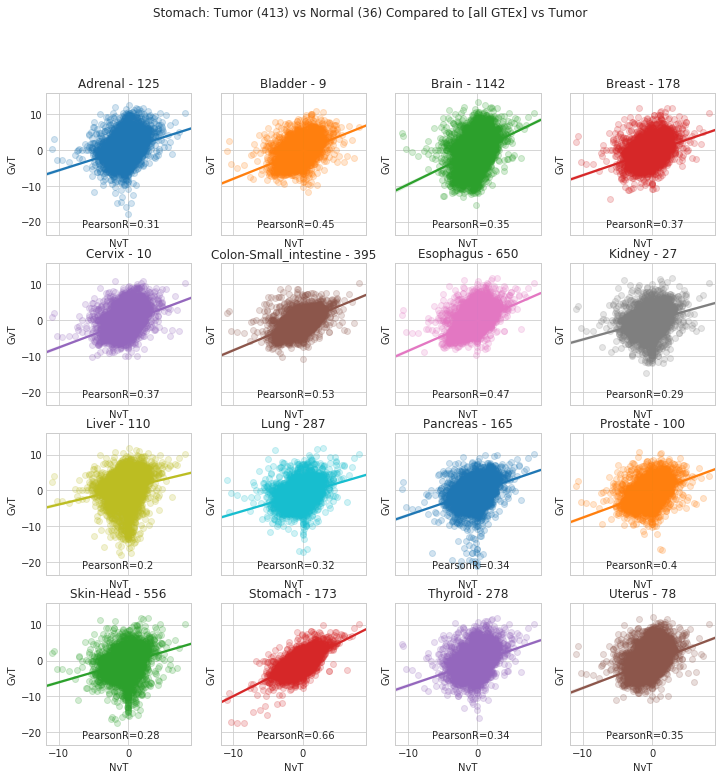

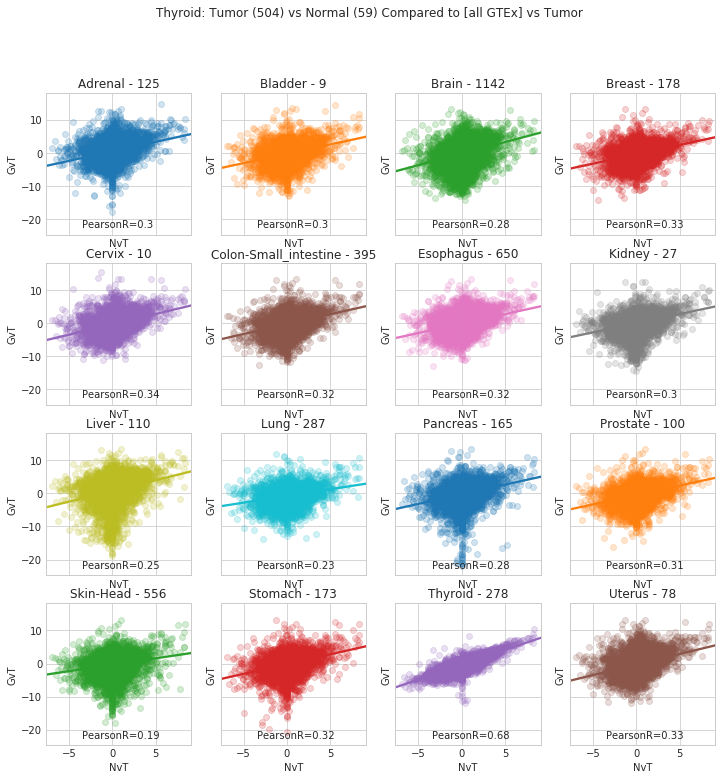

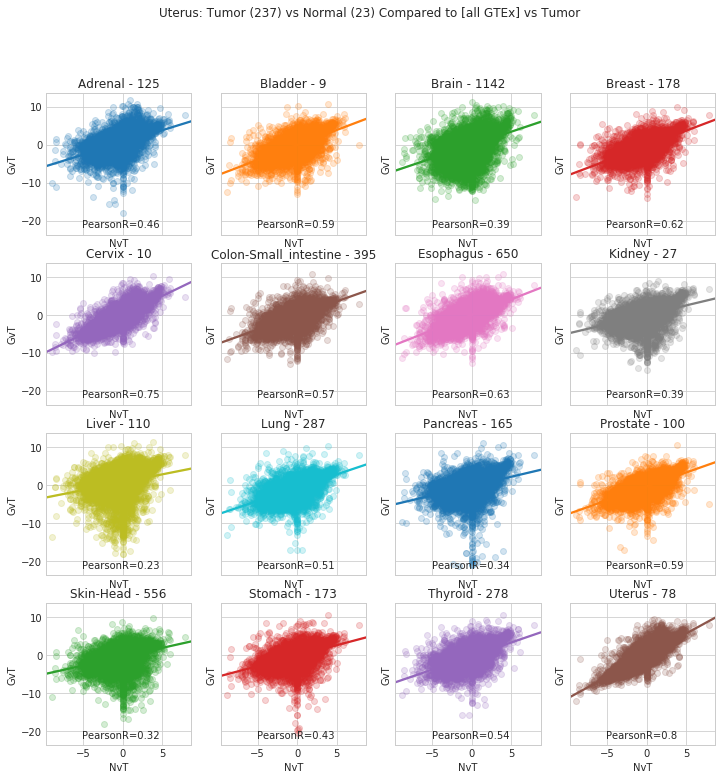

In [60]:
for tissue in normal_tissues:
    # Select GTEx, Tumor, and Normal samples
    t = list(set([x for x in samples[tissue] if x.startswith('TCGA') and x.endswith('01')]))
    n = list(set([x for x in samples[tissue] if x.startswith('TCGA') and x.endswith('11')]))
    
    # Compute l2fc for normal vs. tumor
    t_med = df[t].median(axis=1)
    n_med = df[n].median(axis=1)
    nt_l2fc = get_l2fc(n_med, t_med)
    
    # Define plotting information for this tissue
    f, ax = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12, 12))
    ax = ax.flatten()
    plt.suptitle('{}: Tumor ({}) vs Normal ({}) Compared to [all GTEx] vs Tumor'.format(tissue, len(t), len(n)))
    for i, tissue2 in enumerate(normal_tissues):
        # Compute l2fc between tissue2 GTEx and Tumor
        g = list(set([x for x in samples[tissue2] if not x.startswith('TCGA')]))
        g_med = df[g].median(axis=1)
        gt_l2fc = get_l2fc(g_med, t_med)
        pr = round(pearsonr(nt_l2fc, gt_l2fc)[0], 2)
        
        # Plot
        sns.regplot(x=nt_l2fc, y=gt_l2fc, scatter_kws={'alpha': 0.2}, ax=ax[i])
        ax[i].set_xlabel('NvT')
        ax[i].set_ylabel('GvT')
        ax[i].set_title('{} - {}'.format(tissue2, len(g)))
        ax[i].text(0.25, 0.05, 'PearsonR={}'.format(pr), transform=ax[i].transAxes)
    plt.show()

## Discussion

With the exception of a few tissues with low numbers of normals (< 15 samples), all GTEx tissues produced more concordant fold change values when compared to their TCGA counterpart than when a random GTEx tissue is used. This lends credibility to the idea that while GTEx samples for a tissue are not exactly concordant to their counterpart TCGA normals, they could be used as a substitute in certain cases.